In [1]:
import torch
import triton
import triton.language as tl

In [2]:
@triton.jit
def scale_vector_kernel(x_ptr, scale, out_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    # this program will load block_size number of elements from the vector
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # make sure to define mask such that this program does not access
    # elements outside of the vector
    mask = offsets < n_elements

    # load BLOCK_SIZE number of elements for this program
    x = tl.load(x_ptr + offsets, mask=mask, other=0.0)
    y = x * scale

    # save the scaled values to proper location in output tensor
    tl.store(out_ptr + offsets, y, mask=mask )


def scale_vector(x: torch.Tensor, scale: float):
    output = torch.empty_like(x)
    assert x.is_contiguous()
    n_elements = x.numel()
    block_size = 256
    grid = (triton.cdiv(n_elements, block_size), )
    scale_vector_kernel[grid](x, scale=scale, out_ptr=output, n_elements=n_elements, BLOCK_SIZE=block_size)
    return output

In [3]:
x = torch.tensor([1, 2, 3, 4, 5], device='cuda')
scale_vector(x, scale=2)

tensor([ 2,  4,  6,  8, 10], device='cuda:0')

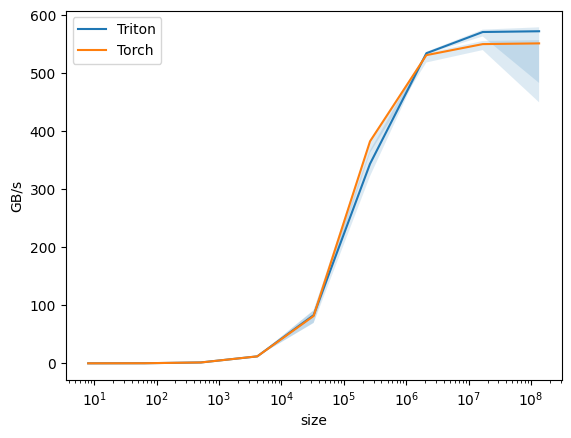

,size,Triton,Torch
0,8.0,0.022556,0.022059
1,64.0,0.175182,0.179104
2,512.0,1.523810,1.500000
3,4096.0,12.000000,12.000000
4,32768.0,83.027023,81.647839
5,262144.0,343.720286,382.505826
6,2097152.0,534.260858,531.014185
7,16777216.0,570.860703,550.000512
8,134217728.0,572.145597,551.259530


In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[8**i for i in range(1, 10)],
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        ylabel='GB/s',
        plot_name='vector-scale-performance',
        args={}
    )
)
def benchmark(size: int, provider: str):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    scale = 10.3

    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x * scale, quantiles=quantiles)
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: scale_vector(x, scale=scale), quantiles=quantiles)
    else:
        raise ValueError(f"unknown provider: {provider}")
    
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(show_plots=True, return_df=True)